In [1]:
import heeps
from heeps.wavefront.get_array import show_wf
from astropy.io import fits
import heeps.util.img_processing as impro
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

### Input parameters and functions

In [2]:
lt1_dist = 54e-3                            # light trap distance upstream of LS
lt1_diam = 33e-3                            # light trap normalized diameter
lt2_dist = 198.7e-3                         # large light trap distance upstream of LS
lt2_diam = 61e-3                            # large light trap normalized diameter
diam_nominal = 38.542                       # m
diam_nominal_METIS = 19.9e-3                # m
scaling = diam_nominal/diam_nominal_METIS
print('scaling = %.2f'%scaling)

scaling = 1936.78


In [3]:
verbose = False
def add_lighttrap(case, **conf):
    wf = heeps.wavefront.add_errors(deepcopy(wf0), phase_screen=phase_screens[0], 
        verbose=verbose, **conf)
    wf = heeps.optics.fp_mask(wf, verbose=verbose, **conf)
    img = show_wf(wf, 'amp', npupil=1024)
    fits.writeto('ls_amp_%s.fits'%case, np.float32(img), overwrite=True)
    wf = heeps.optics.lyot_stop(wf, verbose=verbose, **conf)
    return heeps.optics.detector(wf, verbose=verbose, **conf)
def raw_contrast(case, psfs, psf_OFF):
    # image radius
    rim = psf_OFF.shape[-1] // 2
    # x axis in lam/D
    x = conf['pscale']*1e-3*np.arange(rim)
    # normalize by the peak of the off-axis PSF
    y1 = impro.get_radial_profile(psf_OFF, (rim,rim), 1)[:-1]
    peak = np.max(y1)
    plt.figure(figsize=(9.5, 4))
    for i, psf_ON in enumerate(psfs):
        y2 = impro.get_radial_profile(psf_ON, (rim,rim), 1)[:-1]
        y2 /= peak
        plt.plot(x, y2, label='PSF %s'%(i+1))
    plt.loglog()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.xlabel('Angular separation $[arcsec]$')
    plt.ylabel('raw contrast')
    plt.legend()
    plt.xlim(0.02, 0.75)
    plt.ylim(1e-8,1e-2)
    plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
    plt.savefig('cc_%s.png'%case, dpi=300, transparent=True);

## 1. Propagate with ELT dimensions

In [4]:
conf = dict(
    mode = 'CVC',
    nframes = 1,
    hfov = 0.8,
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_lyot_stop = 'pupil/ls_CVC_L_285_dRext=0.0291_dRint=0.08_dRspi=0.0317.fits',
    f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits',
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(
    verbose=True, **conf)
psf_OFF = heeps.wavefront.propagate_one(deepcopy(wf0), onaxis=False, 
    verbose=True, **conf)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.62 lam/D)

Load pupil from 'ELT_fullM1.fits'
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)
Create single off-axis PSF
   apply lyot stop from 'ls_CVC_L_285_dRext=0.0291_dRint=0.08_dRspi=0.0317.fits'
   extract PSF on the detector: ndet=293


### No light trap

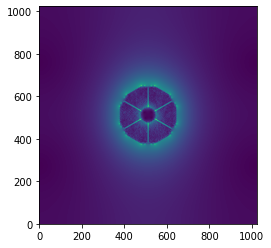

In [5]:
psf1 = add_lighttrap('ELT', **dict(conf, lt_diam=0, lt_dist=0))

### Small light trap

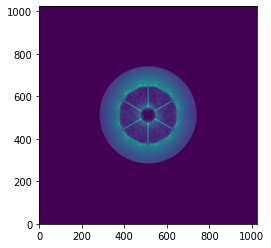

In [6]:
psf2 = add_lighttrap('ELT_small_LT', **dict(conf, lt_diam=lt1_diam*scaling/conf['diam_ext'], 
    lt_dist=lt1_dist*scaling))

### Large light trap

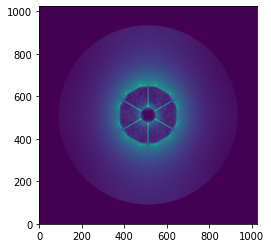

In [7]:
psf3 = add_lighttrap('ELT_large_LT', **dict(conf, lt_diam=lt2_diam*scaling/conf['diam_ext'], 
    lt_dist=lt2_dist*scaling))

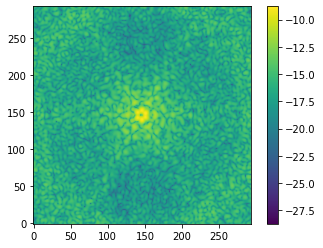

In [8]:
plt.imshow(np.log(psf3), origin='lower'); plt.colorbar()
plt.savefig('PSF_ELT.png', dpi=300, transparent=True);

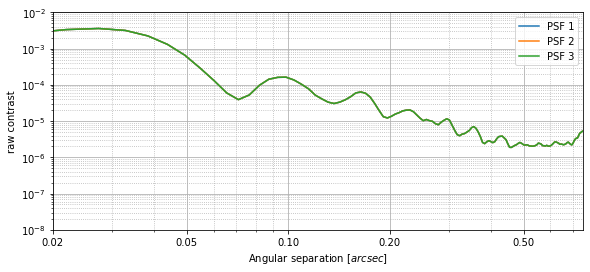

In [9]:
raw_contrast('ELT', [psf1, psf2, psf3], psf_OFF)

## 3. Propagate with METIS dimensions

In [10]:
# rescale to size of beam inside METIS
conf['focal'] /= scaling
conf['pupil_img_size'] /= scaling
conf['diam_nominal'] /= scaling
conf['diam_ext'] /= scaling
conf['diam_int'] /= scaling
conf['spi_width'] /= scaling
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
psf_OFF = heeps.wavefront.propagate_one(deepcopy(wf0), onaxis=False, 
    verbose=True, **conf)

Load pupil from 'ELT_fullM1.fits'
Create single off-axis PSF
   apply lyot stop from 'ls_CVC_L_285_dRext=0.0291_dRint=0.08_dRspi=0.0317.fits'
   extract PSF on the detector: ndet=293


### No light trap

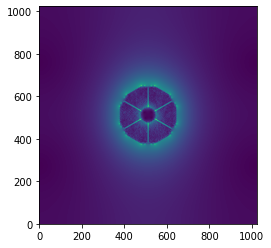

In [11]:
psf1 = add_lighttrap('METIS', **dict(conf, lt_diam=0, lt_dist=0))

### Small light trap

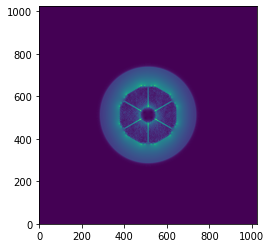

In [12]:
psf2 = add_lighttrap('METIS_small_LT', **dict(conf, lt_diam=lt1_diam/conf['diam_ext'], 
    lt_dist=lt1_dist))

### Large light trap

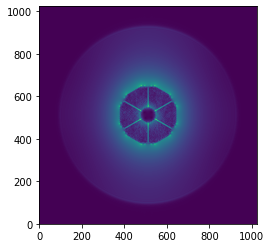

In [13]:
psf3 = add_lighttrap('METIS_large_LT', **dict(conf, lt_diam=lt2_diam/conf['diam_ext'], 
    lt_dist=lt2_dist))

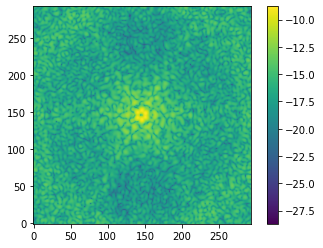

In [14]:
plt.imshow(np.log(psf3), origin='lower'); plt.colorbar()
plt.savefig('PSF_METIS.png', dpi=300, transparent=True);

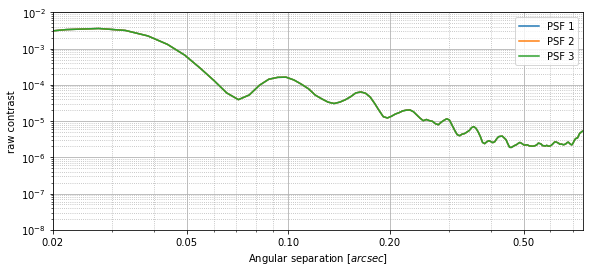

In [15]:
raw_contrast('METIS', [psf1, psf2, psf3], psf_OFF)